In [2]:
import sys
import pandas as pd
import matplotlib
import scipy

def pprint(r,dic):
    
    full_list = []
    for word in sorted(dic,key=lambda x: x[1],reverse=True):
        full_list.append(word[0])
    return full_list

In [5]:
filename = 'onlineforum' # for 'interview' and 'twitter' contexts, replace 'onlineforum' with 'interview' or 'twitter'

import pickle
with open('data/%s.pickle'%filename, 'rb') as handle:
    df=pickle.load(handle)

In [6]:
def mw_custom(df1,df2,df0):
    thr=1.96
    grams={}
    delt = get_log_odds(df1['response'], df2['response'],df0['response'],False) #first one is the positive-valued one

    c1 = []
    c2 = []
    for k,v in delt.items():
        if v > thr:
            c1.append([k,v])
        elif v < -thr:
            c2.append([k,v])

    if 'target' in grams:
        grams['target'].extend(c1)
    else:
        grams['target'] = c1
    return grams['target']


In [9]:
import pandas as pd
import numpy as np
from collections import Counter
import argparse
from collections import defaultdict
import math
import sys
def get_log_odds(df1, df2, df0,verbose=False,lower=True):
    """Monroe et al. Fightin' Words method to identify top words in df1 and df2
    against df0 as the background corpus"""
    if lower:
        counts1 = defaultdict(int,[[i,j] for i,j in df1.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])
        counts2 = defaultdict(int,[[i,j] for i,j in df2.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])
        prior = defaultdict(int,[[i,j] for i,j in df0.str.lower().str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])
    else:
        counts1 = defaultdict(int,[[i,j] for i,j in df1.str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])
        counts2 = defaultdict(int,[[i,j] for i,j in df2.str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])
        prior = defaultdict(int,[[i,j] for i,j in df0.str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])

    sigmasquared = defaultdict(float)
    sigma = defaultdict(float)
    delta = defaultdict(float)

    for word in prior.keys():
        prior[word] = int(prior[word] + 0.5)

    for word in counts2.keys():
        counts1[word] = int(counts1[word] + 0.5)
        if prior[word] == 0:
            prior[word] = 1

    for word in counts1.keys():
        counts2[word] = int(counts2[word] + 0.5)
        if prior[word] == 0:
            prior[word] = 1

    n1 = sum(counts1.values())
    n2 = sum(counts2.values())
    nprior = sum(prior.values())

    for word in prior.keys():
        if prior[word] > 0:
            l1 = float(counts1[word] + prior[word]) / (( n1 + nprior ) - (counts1[word] + prior[word]))
            l2 = float(counts2[word] + prior[word]) / (( n2 + nprior ) - (counts2[word] + prior[word]))
            sigmasquared[word] =  1/(float(counts1[word]) + float(prior[word])) + 1/(float(counts2[word]) + float(prior[word]))
            sigma[word] =  math.sqrt(sigmasquared[word])
            delta[word] = ( math.log(l1) - math.log(l2) ) / sigma[word]

    if verbose:
        for word in sorted(delta, key=delta.get)[:10]:
            print("%s, %.3f" % (word, delta[word]))

        for word in sorted(delta, key=delta.get,reverse=True)[:10]:
            print("%s, %.3f" % (word, delta[word]))
    return delta



# Get Seed Words For Poles

In [10]:
topwords = {}
for t in df['topic'].unique():
    print(t)
    for p in df['persona'].unique():
        tempdf1 = df.loc[(df['persona']=='person')&(df['topic']==t)]
        tempdf2 = df.loc[(df['persona']==p)&(df['topic']=='comment')]
        subdf = df.loc[(df['persona'].isin(['person',p]))&(df['topic'].isin(['comment',t]))]
        ptopwords = pprint(p+' vs. ' +t,mw_custom(tempdf2,tempdf1,subdf))
        ttopwords = pprint(t+' vs. ' +p,mw_custom(tempdf1,tempdf2,subdf))
        if len(ptopwords)>0 and len(ttopwords)>0:
            topwords['%s-VS-%s'%(p,t)] = {p:ptopwords,
                                      t:ttopwords
            }

Arts and Entertainment
How to Read Guitar Music
Cars & Other Vehicles
How to Get Over the Fear of Driving
Computers and Electronics
How to Type on a PDF
Education and Communications
How to Find the Area of a Kite
Family Life
How to Dress For a Funeral
Finance and Business
How to Write a Business Case
Food and Entertaining
How to Make an Egg Wash
Health
How to Shrink Fibroids
Hobbies and Crafts
How to Make Slime
Holidays and Traditions
How to Say Happy Birthday
American Socialism
whether the U.S. should become socialist
Churches & Taxes
whether churches (including mosques, synagogues, etc.) should remain tax-exempt
Reparations for Slavery
whether the federal government should pay reparations to the descendants of slaves
Historic Statue Removal
whether historic statues should be taken down
Medical Marijuana
whether medical marijuana should be legal
Electoral College
whether the United States should use the Electoral College in presidential elections
Minimum Wage
whether the federal minim

# Compute Poles

In [11]:
from nltk.tokenize import sent_tokenize
def get_list_of_sentences(target_df):
    full_list = []
    for c in target_df['response']:
        full_list.extend(sent_tokenize(c))
    return full_list

In [12]:
sentence_lists = {}
for personatopic, dic in topwords.items():
    
    p = personatopic.split('-VS-')[0]
    t = personatopic.split('-VS-')[1]
    
    subdf_unmarked_topic = df.loc[(df.topic==t) & (df.persona=='person')]
    subdf_persona_only = df.loc[(df.topic=='comment') & (df.persona==p)]
    
    topic_sentence_list = []
    persona_sentence_list = []
    
    for word in dic[t]:
        all_sentences = get_list_of_sentences(subdf_unmarked_topic)
        temp_good = [se for se in all_sentences if word in se]
        topic_sentence_list.extend(temp_good)
        
    for word in dic[p]:
        all_sentences = get_list_of_sentences(subdf_persona_only)
        temp_good = [se for se in all_sentences if word in se]
        persona_sentence_list.extend(temp_good)
        

    if len(topic_sentence_list) > 0 and len(persona_sentence_list) > 0:

        sentence_lists[personatopic] = {}
        sentence_lists[personatopic][p] = persona_sentence_list
        sentence_lists[personatopic][t] = topic_sentence_list


In [14]:
with open('data/%s_sentence_embeddings.pickle'%filename, 'rb') as handle:
    emb_dict=pickle.load(handle)

In [16]:
pole_embs = {}
for personatopic in sentence_lists:
    pole_embs[personatopic] = {}
    p = personatopic.split('-VS-')[0]
    t = personatopic.split('-VS-')[1]
    
    plist = sentence_lists[personatopic][p]
    tlist = sentence_lists[personatopic][t]
    
    
    pole_embs[personatopic][p] = np.mean([emb_dict[s] for s in plist],axis=0)
    pole_embs[personatopic][t] = np.mean([emb_dict[s] for s in tlist],axis=0)

In [17]:
axes = {}
for personatopic in pole_embs:
    p = personatopic.split('-VS-')[0]
    t = personatopic.split('-VS-')[1]
    p_pole = pole_embs[personatopic][p]
    t_pole = pole_embs[personatopic][t]
    axes[personatopic] = [p_pole - t_pole, p_pole,t_pole]

# Compute Normalized Similarities to Axes

In [18]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))
import matplotlib.pyplot as plt

In [19]:
topics = ['Arts and Entertainment', 'How to Read Guitar Music',
       'Cars & Other Vehicles', 'How to Get Over the Fear of Driving',
       'Computers and Electronics', 'How to Type on a PDF',
       'Education and Communications', 'How to Find the Area of a Kite',
       'Family Life', 'How to Dress For a Funeral',
       'Finance and Business', 'How to Write a Business Case',
       'Food and Entertaining', 'How to Make an Egg Wash', 'Health',
       'How to Shrink Fibroids', 'Hobbies and Crafts',
       'How to Make Slime', 'Holidays and Traditions',
       'How to Say Happy Birthday', 
           'Home and Garden',
       'How to Get Rid of Ants in the House', 'Personal Care and Style',
       'How to Style Naturally Curly Hair', 'Pets and Animals',
       'How to Care for Dogs', 'Philosophy and Religion',
       'How to Create Your Own Birth Chart', 'Relationships',
       'How to Know if You Love Someone', 
          'American Socialism',
       'whether the U.S. should become socialist', 'Churches & Taxes',
       'whether churches (including mosques, synagogues, etc.) should remain tax-exempt',
       'Reparations for Slavery',
       'whether the federal government should pay reparations to the descendants of slaves',
       'Historic Statue Removal',
       'whether historic statues should be taken down',
       'Medical Marijuana', 'whether medical marijuana should be legal',
       'Electoral College',
       'whether the United States should use the Electoral College in presidential elections',
       'Minimum Wage',
       'whether the federal minimum wage should be increased',
       'Universal Basic Income (UBI)',
       'whether the United States should implement a universal basic income',
       'Paying College Athletes',
       'whether colleges and universities should pay college athletes',
       'Illegal Immigration',
       'whether the U.S. government should provide a path to citizenship for undocumented immigrants',
       'Abortion', 'whether abortion should be legal',
       'OTC Birth Control Pills',
       'whether birth control pills should be available over-the-counter (OTC)',
          'Golf',
       'whether golf is a sport and golfers are athletes', 'GMOs',
       'whether genetically modified organisms (GMOs) should be grown',
       'Saturday Halloween',
       'whether Halloween should be moved permanently to Saturday','comment']
topic_order = []
for i,t in enumerate(topics):
    if i % 2 == 0 and t!='comment':
        topic_order.append(t)
for i,t in enumerate(topics):
    if i % 2 == 1:
        topic_order.append(t)

evens = [ topics[i] for i in range(len(topics)) if i%2==0] #general topics
odds =[ topics[i] for i in range(len(topics)) if i%2==1]  #specific topics

In [20]:
def rescale(x,sm,bi):
    return (x-sm)/(bi-sm)

In [21]:
topic_dict_res = {}
persona_dict_res = {}
for personatopic in sentence_lists.keys():
            pt = personatopic.split('-VS-')
            p=pt[0]
            t= pt[1]
            if p!= 'person':

                df_imp = df.loc[(df.topic==t)&(df.persona==p)]
        #         print(df_imp)
                df_control_t = df.loc[(df.topic==t)&(df.persona=='person')]
                df_control_p = df.loc[(df.topic=='comment')&(df.persona==p)]
                sims = [cos_sim(x,axes[personatopic][0]) for x in df_imp['embeddings']]
                sims_t = [cos_sim(x,axes[personatopic][0]) for x in df_control_t['embeddings']]
                sims_p = [cos_sim(x,axes[personatopic][0]) for x in df_control_p['embeddings']]
                avg_sim=np.mean(sims)
                if t in topic_dict_res:
                    temp = topic_dict_res[t]
                    temp.append((p,rescale(avg_sim,np.mean(sims_t),np.mean(sims_p))))
                else:
                    topic_dict_res[t] = [(p,rescale(avg_sim,np.mean(sims_t),np.mean(sims_p)))]

                if p in persona_dict_res:
                    temp = persona_dict_res[p]
                    temp.append((t,rescale(avg_sim,np.mean(sims_t),np.mean(sims_p))))
                else:
                    persona_dict_res[p] = [(t,rescale(avg_sim,np.mean(sims_t),np.mean(sims_p)))]

/opt/homebrew/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Results

In [22]:
temps = []
for t in df.persona.unique():
    if t in persona_dict_res:
        temps.append([t,np.mean([y for x,y in persona_dict_res[t]])])
#     print('%s mean: %.2f'%(t,))
print("MOST TO LEAST CARICATURED PERSONAS")
for x,y in sorted(temps,key=lambda a:a[1],reverse=True):
    print('\\textit{%s} (%.2f),'%(x,y))

MOST TO LEAST CARICATURED PERSONAS
\textit{nonbinary person} (0.36),
\textit{Hispanic person} (0.26),
\textit{Black person} (0.25),
\textit{Middle-Eastern person} (0.24),
\textit{conservative person} (0.22),
\textit{liberal person} (0.22),
\textit{Asian person} (0.20),
\textit{white person} (0.18),
\textit{80-year-old person} (0.16),
\textit{20-year-old person} (0.12),
\textit{40-year-old person} (0.11),
\textit{moderate person} (0.11),
\textit{woman} (0.05),
\textit{man} (0.03),
\textit{60-year-old person} (nan),


In [23]:
temps = []
for t in df.topic.unique():
    temps.append([t,np.nanmean([y for x,y in topic_dict_res[t]])])
#     print('%s mean: %.2f'%(t,))
print("MOST TO LEAST CARICATURED TOPICS")
for x,y in sorted(temps,key=lambda a:a[1],reverse=True):
    print('\\textit{%s} (%.2f),'%(x,y))

MOST TO LEAST CARICATURED TOPICS
\textit{comment} (1.00),
\textit{Health} (0.42),
\textit{Philosophy and Religion} (0.39),
\textit{Education and Communications} (0.39),
\textit{Relationships} (0.39),
\textit{Finance and Business} (0.36),
\textit{Computers and Electronics} (0.36),
\textit{Family Life} (0.35),
\textit{Arts and Entertainment} (0.34),
\textit{Personal Care and Style} (0.31),
\textit{Holidays and Traditions} (0.27),
\textit{Cars & Other Vehicles} (0.25),
\textit{Golf} (0.24),
\textit{Home and Garden} (0.24),
\textit{Food and Entertaining} (0.23),
\textit{Pets and Animals} (0.22),
\textit{Hobbies and Crafts} (0.21),
\textit{How to Know if You Love Someone} (0.21),
\textit{Illegal Immigration} (0.20),
\textit{How to Write a Business Case} (0.19),
\textit{How to Say Happy Birthday} (0.19),
\textit{Abortion} (0.19),
\textit{Medical Marijuana} (0.18),
\textit{whether abortion should be legal} (0.16),
\textit{American Socialism} (0.15),
\textit{Electoral College} (0.15),
\textit{

## Plot exaggeration scores

(0.0, 1.0)

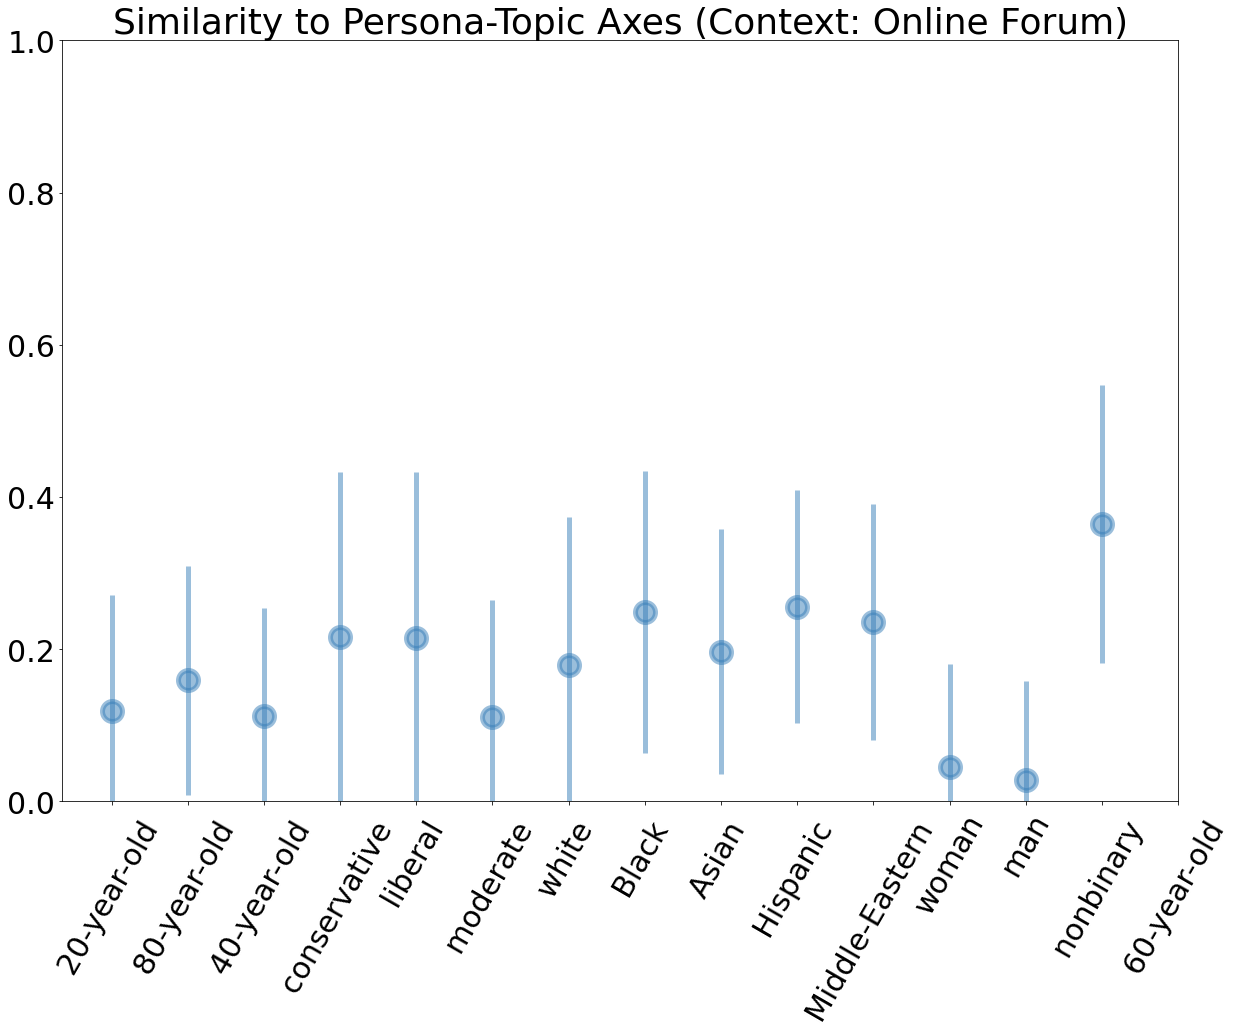

In [32]:
CB = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(20,14))
plt.title('Similarity to Persona-Topic Axes (Context: Online Forum)')


p_dict = {}
for t in topics:
    for x,y in topic_dict_res[t]:
        if x in p_dict:
            p_dict[x].append(y)
        else:
            p_dict[x] = [y]
plt.errorbar(range(len(p_dict.keys())), [np.mean(v) for p, v in p_dict.items()], [np.std(v)for p, v in p_dict.items()],elinewidth=5,color=CB[0],marker='o',
    
 ms=20, mew=5,linewidth=0,alpha=0.5)
#     print(p_dict)

parse_labels = []
for x,y in topic_dict_res[t]:
    if x =='person':
        parse_labels.append('person\n(default-persona)')
    elif 'person' in x:
        parse_labels.append(x.split('person')[0])
    else:
        parse_labels.append(x)
plt.xticks(ticks=range(len(persona_dict_res.keys())),labels=parse_labels,rotation=60)
plt.ylim(0,1)

# Plot by Topic Group (for Online Forum Context)

In [33]:

group_colors = {'Wikihow general':CB[0],'ProCon general':CB[0],'WikiHow specific':CB[1],'ProCon specific':CB[1]}

groups = {'Wikihow general':evens[:15],'ProCon general':evens[15:-1],'WikiHow specific':odds[:15],'ProCon specific':odds[15:]}
group_m = {'Wikihow general':'o','ProCon general':'*','WikiHow specific':'o','ProCon specific':'*'}


In [34]:
age_features = ['20-year-old person',
 '80-year-old person',
 '40-year-old person']

political_features = [
 'conservative person',
 'moderate person',
 'liberal person']

race_features = ['white person',
 'Black person',
 'Asian person',
 'Middle-Eastern person',
 'Hispanic person']

gender_features = ['woman',
 'man',
 'nonbinary person']


In [35]:
plot_dfs = {}
for grp_name, grp_list in groups.items():
#     plot_dfs[grp_name] = {}
    p_dict = {}
    for t in topic_order:
        if t in grp_list:
            for x,y in topic_dict_res[t]:
                if x in p_dict:
                    p_dict[x].append(y)
                else:
                    p_dict[x] = [y]

    plot_df = []
    for k, v in p_dict.items():
        plot_df.append({"Feature": k, "Mean": np.mean(v), "StdError": scipy.stats.sem(v)})

    plot_df = pd.DataFrame(plot_df)
    plot_dfs[grp_name] = plot_df


In [36]:
import seaborn as sns
matplotlib.rc('pdf', fonttype=42)

sns.set_context("paper")
sns.set(font_scale = 1.3)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

def apply_style(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.margins(0.2)
    for yval in np.arange(0.1,0.61,0.1):
        ax.axhline(y=yval, linestyle='--', color='black', linewidth=1, alpha=0.3)


    
def plot_group(ax, title, plot_df, grpname):
    ax.set_ylim(-0.06,0.63)
    plot_df['Feature'] = plot_df['Feature'].apply(lambda r: r.replace("person", "")
                                        .replace("-", " ").strip().capitalize())
    plot_df['Feature'] = plot_df['Feature'].apply(lambda r: r.replace(" year old", ""))
    plot_df['Feature'] = plot_df['Feature'].apply(lambda r: r.replace("Middle eastern", "Middle-\nEastern"))
    plot_df['Feature'] = plot_df['Feature'].apply(lambda r: r.replace("Nonbinary", "Non-\nBinary"))
    plot_df['Feature'] = plot_df['Feature'].apply(lambda r: r.replace("Conservative", "Conser-\nvative"))
    plot_df = plot_df.sort_values("Feature")
    color = group_colors[grpname]
    ax.set_title(title)
    if 'general' in grpname:
        ax.errorbar(plot_df.Feature, plot_df.Mean, plot_df.StdError, linewidth=0, marker=group_m[grpname], ms=20,
    mew=3,                elinewidth=3, color=color, alpha=0.7,label=grpname)
    else:
        ax.errorbar(plot_df.Feature, plot_df.Mean, plot_df.StdError, linewidth=0, marker=group_m[grpname], ms=10,
    mew=3,                elinewidth=3, color=color, alpha=0.7,label=grpname)
    ax.tick_params(axis='x', labelrotation = 0)
    apply_style(ax)

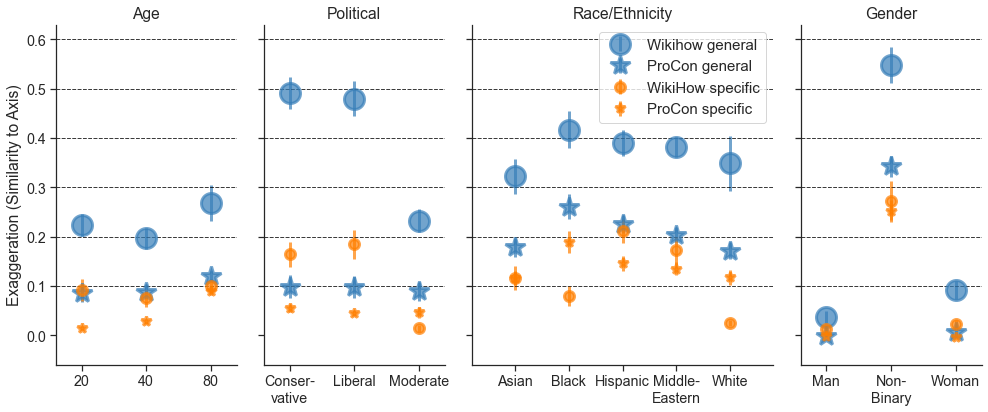

In [37]:

CB = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
group_colors = {'Wikihow general':CB[0],'ProCon general':CB[0],'WikiHow specific':CB[1],'ProCon specific':CB[1]}

f, (a0, a1, a2, a3) = plt.subplots(1, 4, figsize=(14, 6), 
                                   gridspec_kw={'width_ratios': [3, 3, 5, 3]}, 
                                   sharey=True)
for k,plot_df in plot_dfs.items():
    a0.set_ylabel('Exaggeration (Similarity to Axis)')

    age = plot_df[plot_df.Feature.isin(age_features)].copy()
    plot_group(a0, "Age", age, k)

    political = plot_df[plot_df.Feature.isin(political_features)].copy()
    plot_group(a1, "Political", political, k)

    race = plot_df[plot_df.Feature.isin(race_features)].copy()
    plot_group(a2, "Race/Ethnicity", race, k)
    a2.legend(loc='upper right',fontsize=15)

    gender = plot_df[plot_df.Feature.isin(gender_features)].copy()
    plot_group(a3, "Gender", gender, k)
    f.tight_layout()